In [4]:
from datasets import load_dataset

# dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v5_upscale_2x_raw"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
# dataset_name = "dim/render_nfs_4screens_6_sdxl_1_wan_mix"
dataset_name = "dim/render_nfs_4screens_5_sdxl_1_wan_mix"
dataset = load_dataset(
    dataset_name,
    cache_dir=f"/code/dataset/{dataset_name.split('/')[-1]}",
)
# dataset["train"] = dataset["train"].shuffle(seed=2025)
dataset = dataset["train"]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
dataset[0]

{'input_image': <PIL.TiffImagePlugin.TiffImageFile image mode=P size=832x480>,
 'edited_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=832x480>,
 'edit_prompt': ''}

In [1]:
from PIL import Image
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
    StableDiffusionImg2ImgPipeline,
    AutoencoderTiny,
    UNet2DModel,
    FlowMatchEulerDiscreteScheduler,
)
import numpy as np
import torch
from torchvision import transforms
from auto_remaster.sandbox.flux2_tiny_autoencoder import Flux2TinyAutoEncoder

noise_scheduler = FlowMatchEulerDiscreteScheduler()

# 1. Загрузка VAE (Tiny Autoencoder для скорости и экономии памяти)
# vae_val = AutoencoderTiny.from_pretrained(
#     "madebyollin/taesd",
#     torch_device="cuda",
#     torch_dtype=weight_dtype,
# ).to(accelerator.device)
# vae_val.decoder.ignore_skip = False
weight_dtype = torch.bfloat16
# weight_dtype = torch.float32
device = "cuda"
resolution = 512
# resolution = 480
# resolution = 512 * 2
# checkpoint_path = "checkpoints/auto_remaster/lbm_repae_gan/checkpoint-28800"
# checkpoint_path = "checkpoints/auto_remaster/lbm_repae_gan_v2/checkpoint-30000"
# checkpoint_path = "/code/checkpoints/auto_remaster/lbm_v6_wan_mix/checkpoint-105600"
checkpoint_path = (
    "checkpoints/auto_remaster/lbm_train_test_gap_struct_noise/checkpoint-177600"
    # "checkpoints/auto_remaster/lbm_train_test_gap_struct_noise_v6_upscale_2x_raw/checkpoint-80000"
)
vae_val = AutoencoderKL.from_pretrained(
    # "black-forest-labs/FLUX.1-dev",
    "black-forest-labs/FLUX.2-dev",
    # checkpoint_path,
    subfolder="vae",
    torch_device="cuda",
    torch_dtype=weight_dtype,
).to(device)
# vae_val = Flux2TinyAutoEncoder.from_pretrained(
#     "fal/FLUX.2-Tiny-AutoEncoder",
#     torch_dtype=weight_dtype,
# ).to(device)
vae_val.requires_grad_(False)
vae_val.eval()
# checkpoint_path = "checkpoints/auto_remaster/lbm/checkpoint-28800"
# 2. Загрузка UNet из чекпоинта
unet_val = UNet2DModel.from_pretrained(
    checkpoint_path,
    subfolder="unet",
    torch_dtype=weight_dtype,
).to(device)
unet_val.eval()

# 3. Подготовка трансформаций
valid_transforms = transforms.Compose(
    [
        transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.LANCZOS,
        ),
        transforms.CenterCrop(resolution),
    ]
)
train_transforms = transforms.Compose(
    [
        transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.LANCZOS,
        ),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5),
        ),
    ]
)


# Вспомогательная функция для получения сигм (как в основном скрипте)
def _get_sigmas_val(
    scheduler,
    timesteps,
    n_dim=4,
    dtype=torch.float32,
    device="cpu",
):
    sigmas = scheduler.sigmas.to(device=device, dtype=dtype)
    schedule_timesteps = scheduler.timesteps.to(device)
    timesteps = timesteps.to(device)
    step_indices = [(schedule_timesteps == t).nonzero().item() for t in timesteps]
    sigma = sigmas[step_indices].flatten()
    while len(sigma.shape) < n_dim:
        sigma = sigma.unsqueeze(-1)
    return sigma

config.json:   0%|          | 0.00/770 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at black-forest-labs/FLUX.2-dev were not used when initializing AutoencoderKL: 
 ['bn.running_mean, bn.num_batches_tracked, bn.running_var']


In [15]:
noise_scheduler.timesteps

tensor([1000.,  875.,  750.,  625.,  500.,  375.,  250.,  125.],
       device='cuda:0')

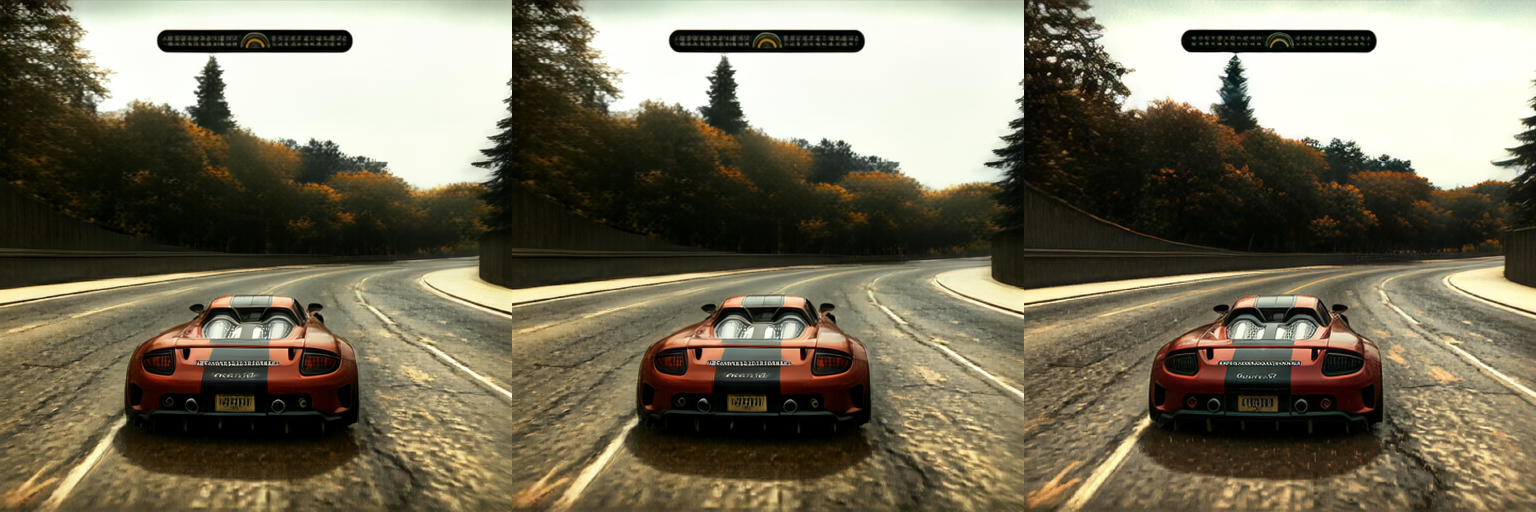

In [6]:
# ---------------------------------------------------------
# НАСТРОЙКА ШЕДУЛЕРА
# ---------------------------------------------------------
from accelerate.utils import ProjectConfiguration, set_seed
from auto_remaster.train_auto_remaster_lbm_train_test_gap_struct_noise import (
    generate_structured_noise_batch_vectorized,
)

# num_steps = 1
num_steps = 8
# num_steps = 40
# num_steps = 1
# bridge_noise_sigma = 0.001
# bridge_noise_sigma = 0.01
bridge_noise_sigma = 0.0
sigmas = np.linspace(1.0, 1 / num_steps, num_steps)

noise_scheduler.set_timesteps(sigmas=sigmas, device=device)

# pos = 20000
# pos = 10000
# pos = 10100
# pos = 10200
# pos = 1727
# pos = 727
# pos = 527
# pos = 327
pos = 256
# pos = 227
# pos = 170
# pos = 0
import random

# test_images_ids = list(range(0, len(dataset), 30))
# rng = random.Random(2025)
# amount = min(30, len(test_images_ids))
# selected_ids = rng.sample(test_images_ids, amount)

# pos = 84
# pos = selected_ids[0]
# pos = selected_ids[24]
# pos = selected_ids[28]
# pos = selected_ids[7]
# pos = 0
item = dataset[pos]
source_image_name = "input_image"
target_image_name = "edited_image"
# Подготовка исходных изображений для визуализации и метрик
orig_source_pil = item[source_image_name].convert("RGB")
target_pil = item[target_image_name].convert("RGB")

noise_scheduler = FlowMatchEulerDiscreteScheduler()


# ---------------------------------------------------------
# НАСТРОЙКА ШЕДУЛЕРА
# ---------------------------------------------------------
# num_steps = diffusion_args.num_inference_steps

sigmas = np.linspace(1.0, 1 / num_steps, num_steps)

noise_scheduler.set_timesteps(sigmas=sigmas, device="cuda")

set_seed(2025)
item = dataset[pos]

# Подготовка исходных изображений для визуализации и метрик
orig_source_pil = item[source_image_name].convert("RGB")
target_pil = item[target_image_name].convert("RGB")

source_tensor = valid_transforms(orig_source_pil)
target_tensor = valid_transforms(target_pil)

# Подготовка латента source
# Используем train_transforms для кодирования, как в обучении
c_t = (
    train_transforms(orig_source_pil).unsqueeze(0).to(vae_val.dtype).to(vae_val.device)
)


with torch.no_grad():
    # Encode source image
    z_source = (
        # vae_val.encode(c_t, return_dict=False)[0]
        vae_val.encode(c_t, return_dict=False)[0].sample()
        * vae_val.config.scaling_factor
    )
    structured_noise = generate_structured_noise_batch_vectorized(
        z_source.float(),  # float обязателен для FFT
        noise_std=1.0,
        pad_factor=1.5,
        cutoff_radius=20,  # Фиксированный радиус для валидации
        input_noise=torch.randn_like(z_source.float()),
        sampling_method="fft",
    ).to(dtype=z_source.dtype, device=z_source.device)

    # sample = z_source
    sample = z_source + structured_noise * bridge_noise_sigma

    # ---------------------------------------------------------
    # ЦИКЛ СЭМПЛИНГА (Адаптировано из sample())
    # ---------------------------------------------------------
    # for i, t in enumerate(noise_scheduler.timesteps):
    for i in range(num_steps):
        t = noise_scheduler.timesteps[i]
        # 1. Масштабирование входа (если требуется шедулером)
        if hasattr(noise_scheduler, "scale_model_input"):
            denoiser_input = noise_scheduler.scale_model_input(sample, t)
        else:
            denoiser_input = sample
        denoiser_input = torch.cat([denoiser_input, z_source], dim=1)
        # 2. Предсказание направления (UNet)
        # unet_val(x, t) -> output
        # print(i, t, noise_scheduler.timesteps)
        pred = unet_val(
            denoiser_input,
            t.to(z_source.device).repeat(denoiser_input.shape[0]),
            return_dict=False,
        )[0]

        # 3. Шаг диффузии (Reverse Process)
        sample = noise_scheduler.step(pred, t, sample, return_dict=False)[0]

        # 4. Добавление стохастичности (Bridge Noise)
        # Не добавляем шум после последнего шага
        if i < len(noise_scheduler.timesteps) - 1:
            # Получаем таймстемп следующего шага
            next_timestep = (
                noise_scheduler.timesteps[i + 1]
                .to(z_source.device)
                .repeat(sample.shape[0])
            )

            # Получаем сигму для следующего шага
            sigmas_next = _get_sigmas_val(
                noise_scheduler,
                next_timestep,
                n_dim=4,
                dtype=weight_dtype,
                device=z_source.device,
            )

            # Формула Bridge Matching: шум пропорционален sqrt(sigma * (1-sigma))
            # noise = torch.randn_like(sample)
            structured_noise = generate_structured_noise_batch_vectorized(
                z_source.float(),  # float обязателен для FFT
                noise_std=1.0,
                pad_factor=1.5,
                cutoff_radius=20.0,  # Фиксированный радиус для валидации
                input_noise=torch.randn_like(z_source.float()),
                sampling_method="fft",
            ).to(dtype=sample.dtype, device=sample.device)
            noise = structured_noise
            bridge_factor = (sigmas_next * (1.0 - sigmas_next)) ** 0.5

            sample = sample + bridge_noise_sigma * bridge_factor * noise
            sample = sample.to(z_source.dtype)

    # ---------------------------------------------------------

    # Декодирование результата
    output_image = (
        vae_val.decode(
            sample / vae_val.config.scaling_factor,
            return_dict=False,
        )[0]
    ).clamp(-1, 1)

    pred_image_pil = transforms.ToPILImage()(output_image[0].cpu().float() * 0.5 + 0.5)

many_steps = pred_image_pil.convert("RGB")
num_steps = 1
sigmas = np.linspace(1.0, 1 / num_steps, num_steps)

noise_scheduler.set_timesteps(sigmas=sigmas, device="cuda")
c_t = (
    train_transforms(orig_source_pil).unsqueeze(0).to(vae_val.dtype).to(vae_val.device)
)

with torch.no_grad():
    # Encode source image
    z_source = (
        # vae_val.encode(c_t, return_dict=False)[0]
        vae_val.encode(c_t, return_dict=False)[0].sample()
        * vae_val.config.scaling_factor
    )
    structured_noise = generate_structured_noise_batch_vectorized(
        z_source.float(),  # float обязателен для FFT
        noise_std=1.0,
        pad_factor=1.5,
        cutoff_radius=20,  # Фиксированный радиус для валидации
        input_noise=torch.randn_like(z_source.float()),
        sampling_method="fft",
    ).to(dtype=z_source.dtype, device=z_source.device)

    # sample = z_source
    sample = z_source + structured_noise * bridge_noise_sigma

    # ---------------------------------------------------------
    # ЦИКЛ СЭМПЛИНГА (Адаптировано из sample())
    # ---------------------------------------------------------
    # for i, t in enumerate(noise_scheduler.timesteps):
    for i in range(num_steps):
        t = noise_scheduler.timesteps[i]
        # 1. Масштабирование входа (если требуется шедулером)
        if hasattr(noise_scheduler, "scale_model_input"):
            denoiser_input = noise_scheduler.scale_model_input(sample, t)
        else:
            denoiser_input = sample
        denoiser_input = torch.cat([denoiser_input, z_source], dim=1)
        # 2. Предсказание направления (UNet)
        # unet_val(x, t) -> output
        # print(i, t, noise_scheduler.timesteps)
        pred = unet_val(
            denoiser_input,
            t.to(z_source.device).repeat(denoiser_input.shape[0]),
            return_dict=False,
        )[0]

        # 3. Шаг диффузии (Reverse Process)
        sample = noise_scheduler.step(pred, t, sample, return_dict=False)[0]

        # 4. Добавление стохастичности (Bridge Noise)
        # Не добавляем шум после последнего шага
        if i < len(noise_scheduler.timesteps) - 1:
            # Получаем таймстемп следующего шага
            next_timestep = (
                noise_scheduler.timesteps[i + 1]
                .to(z_source.device)
                .repeat(sample.shape[0])
            )

            # Получаем сигму для следующего шага
            sigmas_next = _get_sigmas_val(
                noise_scheduler,
                next_timestep,
                n_dim=4,
                dtype=weight_dtype,
                device=z_source.device,
            )

            # Формула Bridge Matching: шум пропорционален sqrt(sigma * (1-sigma))
            noise = torch.randn_like(sample)
            bridge_factor = (sigmas_next * (1.0 - sigmas_next)) ** 0.5

            sample = sample + bridge_noise_sigma * bridge_factor * noise
            sample = sample.to(z_source.dtype)

    # ---------------------------------------------------------

    # Декодирование результата
    output_image = (
        vae_val.decode(
            sample / vae_val.config.scaling_factor,
            return_dict=False,
        )[0]
    ).clamp(-1, 1)

    pred_image_pil = transforms.ToPILImage()(output_image[0].cpu().float() * 0.5 + 0.5)

steps_1 = pred_image_pil.convert("RGB")

from jupyter_compare_view import compare

# compare(img, grayscale_img, cmap="gray", start_mode="horizontal", start_slider_pos=0.73)
# grayscale_img
Image.fromarray(
    np.hstack(
        (
            # np.array(source_tensor),
            np.array(steps_1),
            np.array(many_steps),
            np.array(target_tensor),
        )
    )
)


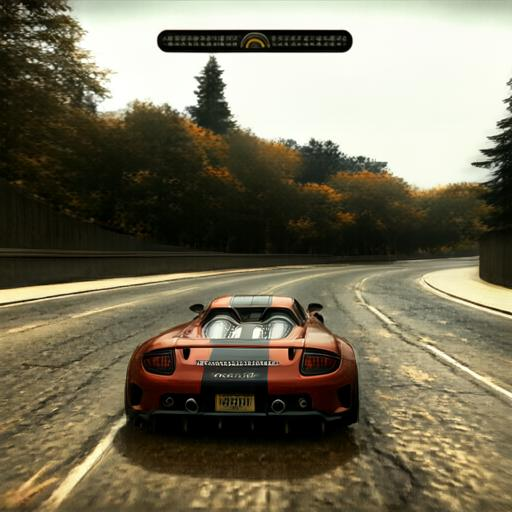
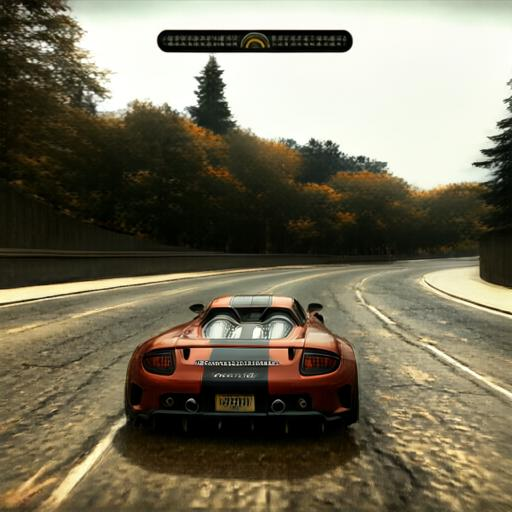

In [7]:
compare(
    steps_1, many_steps, cmap="gray", start_mode="horizontal", start_slider_pos=0.73
)


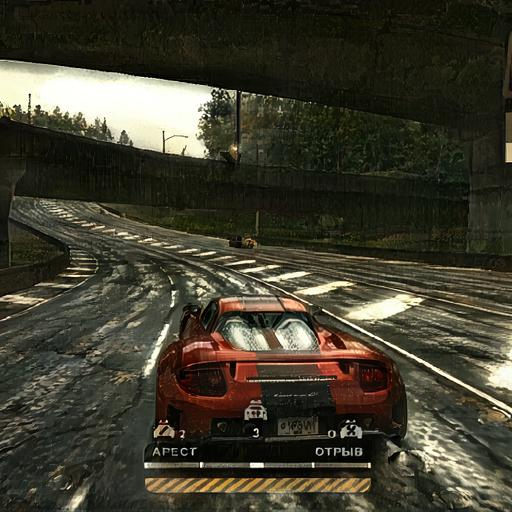
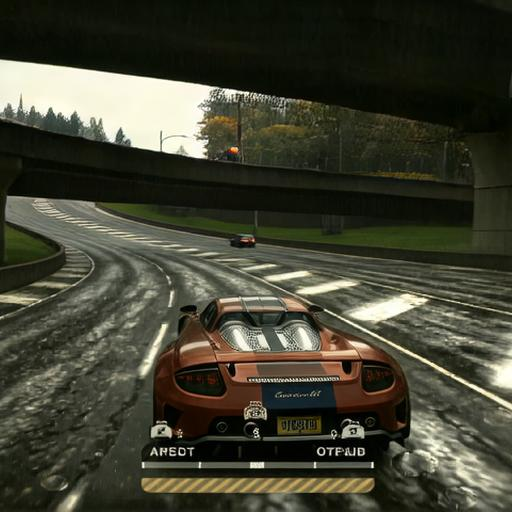

In [9]:
compare(
    many_steps,
    target_tensor,
    cmap="gray",
    start_mode="horizontal",
    start_slider_pos=0.73,
)


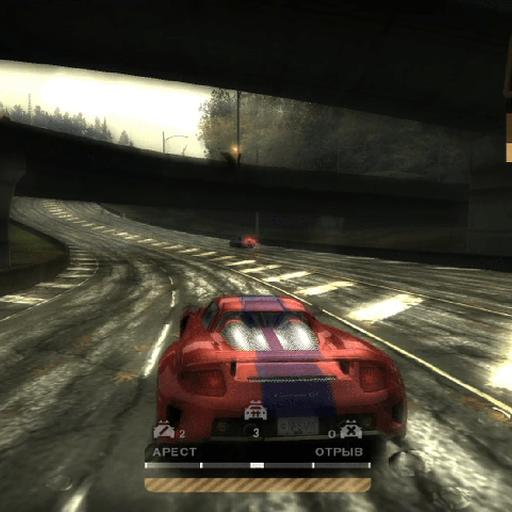
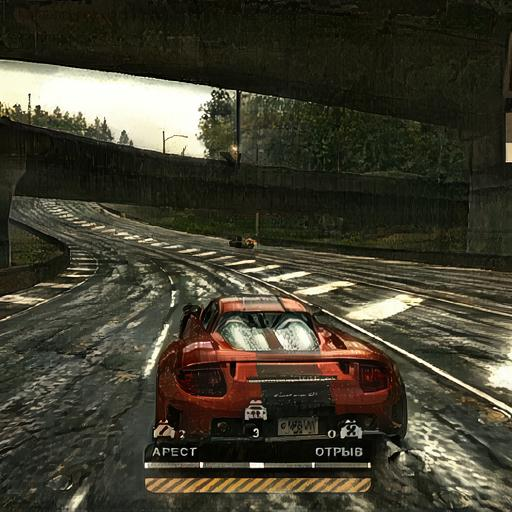

In [10]:
compare(
    source_tensor, steps_1, cmap="gray", start_mode="horizontal", start_slider_pos=0.73
)

In [ ]:
# unet_val.push_to_hub(
#     "dim/lbm_train_test_gap_struct_noise_6_sdxl_1_wan_mix_177600",
#     subfolder="unet",
# )

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/dim/lbm_train_test_gap_struct_noise_6_sdxl_1_wan_mix_177600/commit/213ac8940bbd83f0de413e6aa56950e38f826357', commit_message='Upload model', commit_description='', oid='213ac8940bbd83f0de413e6aa56950e38f826357', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dim/lbm_train_test_gap_struct_noise_6_sdxl_1_wan_mix_177600', endpoint='https://huggingface.co', repo_type='model', repo_id='dim/lbm_train_test_gap_struct_noise_6_sdxl_1_wan_mix_177600'), pr_revision=None, pr_num=None)

In [ ]:
# vae_val.push_to_hub(
#     "dim/lbm_train_test_gap_struct_noise_6_sdxl_1_wan_mix_177600",
#     subfolder="vae",
# )

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/dim/lbm_train_test_gap_struct_noise_6_sdxl_1_wan_mix_177600/commit/5ab977dbbf83cbe16821a3f02855604a6b5e82b6', commit_message='Upload AutoencoderKL', commit_description='', oid='5ab977dbbf83cbe16821a3f02855604a6b5e82b6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dim/lbm_train_test_gap_struct_noise_6_sdxl_1_wan_mix_177600', endpoint='https://huggingface.co', repo_type='model', repo_id='dim/lbm_train_test_gap_struct_noise_6_sdxl_1_wan_mix_177600'), pr_revision=None, pr_num=None)

In [6]:
dataset[pos]

{'input_image': <PIL.PngImagePlugin.PngImageFile image mode=P size=1920x1080>,
 'edit_prompt': 'make nfs 2005 photorealistic',
 'edited_image': <PIL.PngImagePlugin.PngImageFile image mode=P size=1920x1080>}


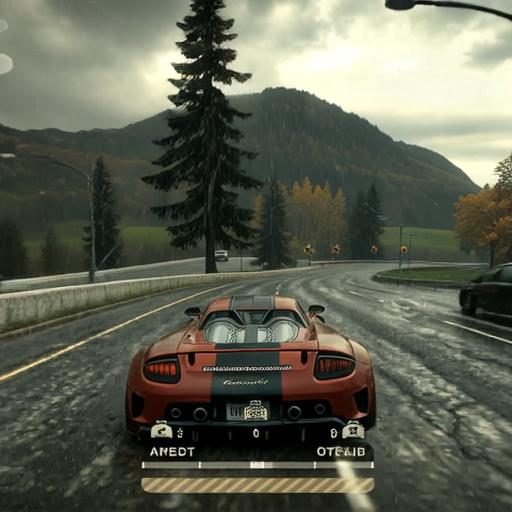
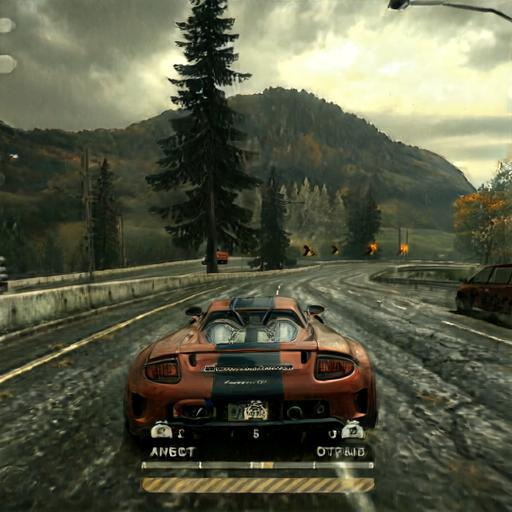

In [31]:
# img = valid_transforms(dataset[pos]["input_image"]).convert("RGB")
img = valid_transforms(dataset[pos]["edited_image"]).convert("RGB")
grayscale_img = pred_image_pil.convert("RGB")

from jupyter_compare_view import compare

compare(img, grayscale_img, cmap="gray", start_mode="horizontal", start_slider_pos=0.73)

In [ ]:
dataset[10000]["edited_image"]

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


count_parameters(unet_val)
# 246_336_352

246336352

In [ ]:
import numpy as np

np.random.exponential(scale=1 / 0.1)

35.5262249874997

total 16.477728366851807s, 0.04119432091712952s per img 24.275190796607543fps


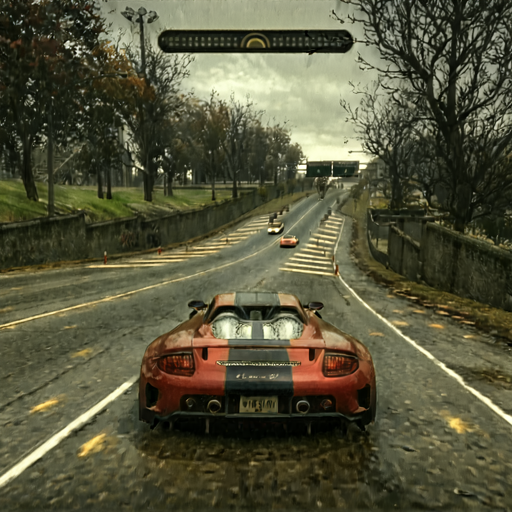

In [59]:
import time

amount = 400
start = time.time()
num_steps = 2
for _ in range(amount):
    # c_t = (
    #     train_transforms(orig_source_pil)
    #     .unsqueeze(0)
    #     .to(vae_val.dtype)
    #     .to(vae_val.device)
    # )
    noise_scheduler.set_timesteps(sigmas=sigmas, device=device)

    with torch.no_grad():
        # Encode source image
        z_source = (
            # vae_val.encode(c_t, return_dict=False)[0]
            vae_val.encode(c_t, return_dict=False)[0].sample()
            * vae_val.config.scaling_factor
        )

        # sample = z_source

        # # ---------------------------------------------------------
        # # ЦИКЛ СЭМПЛИНГА (Адаптировано из sample())
        # # ---------------------------------------------------------
        # # for i, t in enumerate(noise_scheduler.timesteps):
        # for i in range(num_steps):
        #     t = noise_scheduler.timesteps[i]
        #     # 1. Масштабирование входа (если требуется шедулером)
        #     if hasattr(noise_scheduler, "scale_model_input"):
        #         denoiser_input = noise_scheduler.scale_model_input(sample, t)
        #     else:
        #         denoiser_input = sample

        #     # 2. Предсказание направления (UNet)
        #     # unet_val(x, t) -> output
        #     # print(i, t, noise_scheduler.timesteps)
        #     pred = unet_val(
        #         denoiser_input,
        #         t.to(z_source.device).repeat(denoiser_input.shape[0]),
        #         return_dict=False,
        #     )[0]

        #     # 3. Шаг диффузии (Reverse Process)
        #     # Теперь здесь не будет IndexError, т.к. массив sigmas имеет нужный запас
        #     sample = noise_scheduler.step(pred, t, sample, return_dict=False)[0]

        #     # 4. Добавление стохастичности (Bridge Noise)
        #     # Не добавляем шум после последнего шага
        #     if i < len(noise_scheduler.timesteps) - 1:
        #         # Получаем таймстемп следующего шага
        #         next_timestep = (
        #             noise_scheduler.timesteps[i + 1]
        #             .to(z_source.device)
        #             .repeat(sample.shape[0])
        #         )

        #         # Получаем сигму для следующего шага
        #         sigmas_next = _get_sigmas_val(
        #             noise_scheduler,
        #             next_timestep,
        #             n_dim=4,
        #             dtype=weight_dtype,
        #             device=z_source.device,
        #         )

        #         # Формула Bridge Matching: шум пропорционален sqrt(sigma * (1-sigma))
        #         noise = torch.randn_like(sample)
        #         bridge_factor = (sigmas_next * (1.0 - sigmas_next)) ** 0.5

        #         sample = sample + bridge_noise_sigma * bridge_factor * noise
        #         sample = sample.to(z_source.dtype)

        # ---------------------------------------------------------

        # Декодирование результата
        output_image = (
            vae_val.decode(
                sample / vae_val.config.scaling_factor,
                return_dict=False,
            )[0]
        ).clamp(-1, 1)
total = time.time() - start
print(f"total {total}s, {total/amount}s per img {1/(total/amount)}fps")
pred_image_pil = transforms.ToPILImage()(output_image[0].cpu().float() * 0.5 + 0.5)
pred_image_pil